<a href="https://colab.research.google.com/github/anon-researchers/sliced_bures_flows/blob/master/slicing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install POT
! pip install celluloid
! pip install multipledispatch
! git clone https://github.com/anon-researchers/sliced_bures_flows
% cd sliced_bures_flows/src/

     |████████████████████████████████| 440kB 19.7MB/s 
Cloning into 'sliced_bures_flows'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 167 (delta 67), reused 81 (delta 17), pack-reused 0
Receiving objects: 100% (167/167), 31.81 MiB | 42.19 MiB/s, done.
Resolving deltas: 100% (67/67), done.
/content/sliced_bures_flows/src


In [36]:
from utils import load_data
from utils import seed_everything
from utils import rand_Fourier

from utils_slicing import slicing
from utils import rand_projections

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from torch import optim
from celluloid import Camera
from tqdm import tqdm
from IPython import display

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# General settings
seed = 123456
ftype = 'distributional-sliced'
# for Fourier approximation 
RFB = True
sigma = 0.2
bases = 200
radius = 1
# for sliced and distributional-sliced distances
slices = 200
# for distributional-sliced distances
lam = 1
# text for plots
text_RFB = '-----------------\nRFB applied\n#bases={},\nsigma={}\n-----------------\n'.format(bases,sigma) \
            if RFB else '-----------------\nRFB not applied\n-----------------\n'
if ftype=='sliced':
    text_settings = 'r={} for circular slicing,\n#slices={}\n{}'.format(radius,slices,text_RFB)
elif ftype=='max-sliced':
    text_settings = 'r={} for circular slicing,\n#slices=1\n{}'.format(radius,text_RFB)
elif ftype=='distributional-sliced':
    text_settings = 'r={} for circular slicing,\n#slices={}\n{}lam={}'.format(radius,slices,text_RFB,lam)
else:
    raise Exception('function type not found')

In [6]:
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return np.rint(n * multiplier) / multiplier

def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return np.floor(n * multiplier) / multiplier

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return np.ceil(n * multiplier) / multiplier

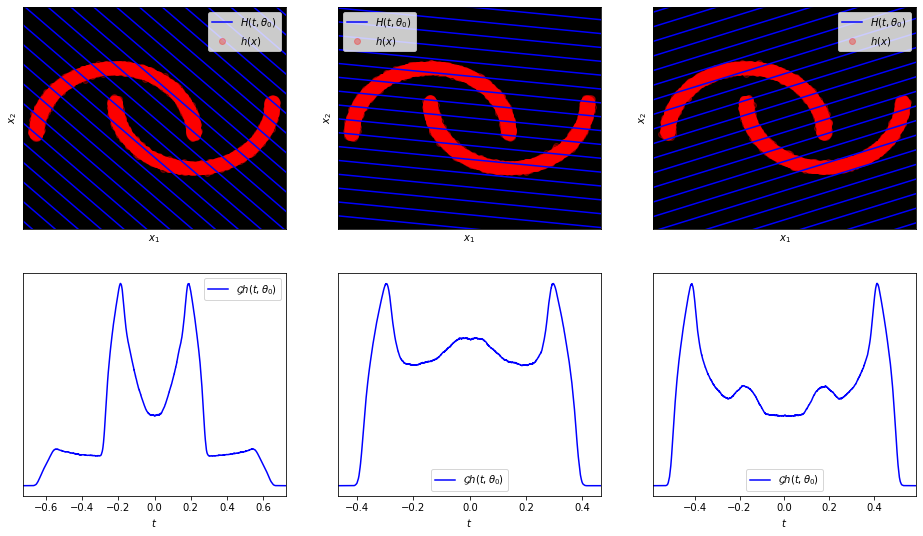

In [27]:
#%%
cols,rows = 3,2
fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(rows*8,cols*3))
N = 100000  # Number of samples from p_X(target) and p_Y(target)
noise = 0.02
# in  ['half_moons','swiss_roll','circle','8gaussians','25gaussians']:
dataset_name = 'half_moons'
sigma = 0.2
bases = 1000
for i,seed in enumerate([1233, 1234, 1235]):
    seed_everything(seed)
    # Target and source distributions
    # Target:
    X = load_data(name=dataset_name, n_samples=N, noise=noise)
    # Number of dimensions "d"
    # _, d = X.shape
    X -= X.mean(dim=0)[np.newaxis,:]  # Normalization
    dim = X.size(1)
    projections = rand_projections(dim, num_projections=1).to(device)
    theta = projections.cpu().numpy().squeeze()
    x1 = np.linspace(X[:,0].min()-0.2, X[:,0].max()+0.2, 1000)
    s = slicing(stype='linear')
    # Show the both distributions
    ax[0][i].scatter(X[:,0], X[:,1], c='red', alpha=0.3, label='$h(x)$')
    ax[0][i].set_facecolor('black')
    ax[0][i].set_yticks([])
    ax[0][i].set_xticks([])
    for num, t in enumerate(np.arange(-1.5,1.5,0.1)):
        ax[0][i].plot(x1, (t-x1*theta[0])/theta[1], c='b', label='$H(t,\\theta_0)$' if num==0 else '')
    ax[0][i].legend()
    # ax.plot(x1, (0.0-x1*projections[0])/projections[1])
    ax[0][i].set_ylim(np.min([X[:,1].min()-0.05,X[:,0].min()-0.05]), np.max([X[:,1].max()+0.05,X[:,0].max()+0.05]))
    ax[0][i].set_xlim(np.min([X[:,1].min()-0.05,X[:,0].min()-0.05]), np.max([X[:,1].max()+0.05,X[:,0].max()+0.05]))
    ax[0][i].set_xlabel('$x_1$')
    ax[0][i].set_ylabel('$x_2$')
    # ax.set_xlim(T[np.array(GI_u)!=0].min()-0.05, T[np.array(GI_u)!=0].max()+0.05)

    slices, _ = s.get_slice(X.to(device),projections=projections)
    slices = slices.cpu().numpy().squeeze()
    T = np.arange(-1,1,0.0001)
    GI_u = []
    for t in T:
        gI_u = np.mean(truncate(t-slices,decimals=1)==0.0)
        GI_u.append(gI_u)
    ax[1][i].plot(T, GI_u, c='b', label='$\mathcal{G}h(t,\\theta_0)$')
    ax[1][i].set_yticks([])
    ax[1][i].set_xlim(T[np.array(GI_u)!=0].min()-0.05, T[np.array(GI_u)!=0].max()+0.05)
    ax[1][i].set_xlabel('$t$')
    ax[1][i].legend()
    # rfb = rand_Fourier(X.shape[1], num_projections=bases, sigma=sigma)
    # X_ = rfb.compute(X)
    # dim = X_.size(1)
    # projections = rand_projections(dim, num_projections=1).to(device)
    # slices, _ = s.get_slice(X_.to(device),projections=projections)
    # slices = slices.cpu().numpy().squeeze()
    # T = np.arange(-1,1,0.0001)
    # GI_u = []
    # for t in T:
    #     gI_u = np.mean(truncate(t-slices,decimals=1)==0.0)
    #     GI_u.append(gI_u)
    # ax[2][i].plot(T, GI_u, c='b')
    # # ax[2][i].set_yticks([])
    # ax[2][i].set_xlim(T[np.array(GI_u)!=0].min()-0.05, T[np.array(GI_u)!=0].max()+0.05)
# plt.scatter(Y[:, 0], Y[:, 1],  c='r', alpha = 0.5)
plt.show()

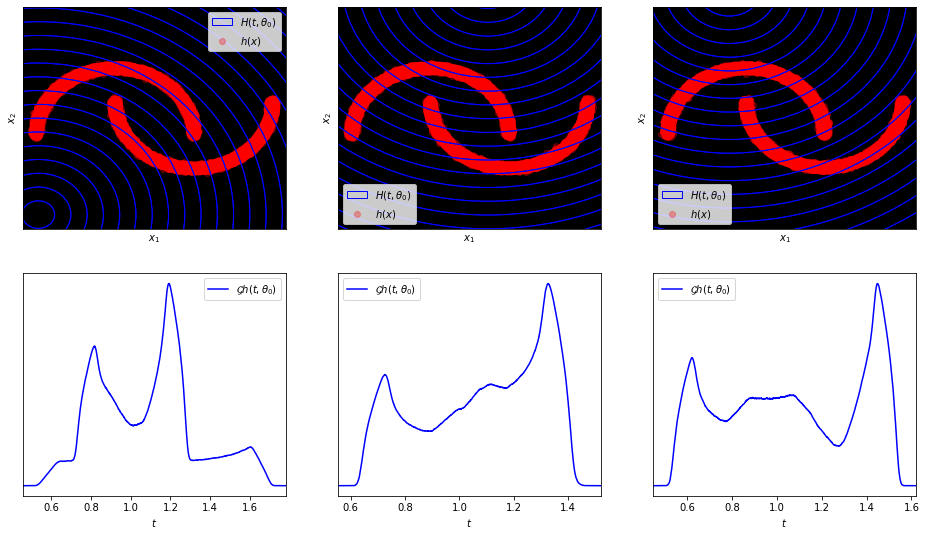

In [42]:
#%%
cols,rows = 3,2
fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(rows*8,cols*3))
N = 100000  # Number of samples from p_X(target) and p_Y(target)
noise = 0.02
# in  ['half_moons','swiss_roll','circle','8gaussians','25gaussians']:
dataset_name = 'half_moons'
sigma = 0.2
bases = 1000
for i,seed in enumerate([1233, 1234, 1235]):
    seed_everything(seed)
    # Target and source distributions
    # Target:
    X = load_data(name=dataset_name, n_samples=N, noise=noise)
    # Number of dimensions "d"
    # _, d = X.shape
    X -= X.mean(dim=0)[np.newaxis,:]  # Normalization
    dim = X.size(1)
    projections = rand_projections(dim, num_projections=1).to(device)
    theta = projections.cpu().numpy().squeeze()
    x1 = np.linspace(X[:,0].min()-0.2, X[:,0].max()+0.2, 1000)
    s = slicing(stype='circular')
    # Show the both distributions
    ax[0][i].scatter(X[:,0], X[:,1], c='red', alpha=0.3, label='$h(x)$')
    ax[0][i].set_facecolor('black')
    ax[0][i].set_yticks([])
    ax[0][i].set_xticks([])
    
    for num,t in enumerate(np.arange(-3,3,0.1)):
        circle = plt.Circle((theta[0], theta[1]), t, color='b', fill=False, label='$H(t,\\theta_0)$' if num==0 else '')
        ax[0][i].add_patch(circle)
        # ax[0][i].plot(x1, (t-x1*theta[0])/theta[1], c='b')
    ax[0][i].legend()
    ax[0][i].set_ylim(np.min([X[:,1].min()-0.05,X[:,0].min()-0.05]), np.max([X[:,1].max()+0.05,X[:,0].max()+0.05]))
    ax[0][i].set_xlim(np.min([X[:,1].min()-0.05,X[:,0].min()-0.05]), np.max([X[:,1].max()+0.05,X[:,0].max()+0.05]))
    ax[0][i].set_xlabel('$x_1$')
    ax[0][i].set_ylabel('$x_2$')
    # ax.set_xlim(T[np.array(GI_u)!=0].min()-0.05, T[np.array(GI_u)!=0].max()+0.05)

    slices, _ = s.get_slice(X.to(device),projections=projections)
    slices = slices.cpu().numpy().squeeze()
    T = np.arange(-3,3,0.0001)
    GI_u = []
    for t in T:
        gI_u = np.mean(truncate(t-slices,decimals=1)==0.0)
        GI_u.append(gI_u)
    ax[1][i].plot(T, GI_u, c='b', label='$\mathcal{G}h(t,\\theta_0)$')
    ax[1][i].set_yticks([])
    ax[1][i].set_xlim(T[np.array(GI_u)!=0].min()-0.05, T[np.array(GI_u)!=0].max()+0.05)
    ax[1][i].set_xlabel('$t$')
    ax[1][i].legend()
    # rfb = rand_Fourier(X.shape[1], num_projections=bases, sigma=sigma)
    # X_ = rfb.compute(X)
    # dim = X_.size(1)
    # projections = rand_projections(dim, num_projections=1).to(device)
    # slices, _ = s.get_slice(X_.to(device),projections=projections)
    # slices = slices.cpu().numpy().squeeze()
    # T = np.arange(-3,3,0.0001)
    # GI_u = []
    # for t in T:
    #     gI_u = np.mean(truncate(t-slices,decimals=1)==0.0)
    #     GI_u.append(gI_u)
    # ax[2][i].plot(T, GI_u, c='b')
    # # ax[2][i].set_yticks([])
    # ax[2][i].set_xlim(T[np.array(GI_u)!=0].min()-0.05, T[np.array(GI_u)!=0].max()+0.05)
# plt.scatter(Y[:, 0], Y[:, 1],  c='r', alpha = 0.5)
plt.show()